<a href="https://colab.research.google.com/github/harichandana2004/tobacco_leaf_detection/blob/main/tobacco_leaves_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from albumentations import Compose, RandomBrightnessContrast, Blur, Rotate
from albumentations.core.composition import OneOf

# Define augmentations (optional)
augmentations = Compose([
    OneOf([
        RandomBrightnessContrast(p=0.5),
        Blur(blur_limit=3, p=0.3)
    ], p=1.0),
    Rotate(limit=30, p=0.5)
])

# Apply background subtraction (set background to black)
def apply_background_subtraction(img):
    # Convert to grayscale for easy thresholding
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary mask (tobacco leaves vs. background)
    _, binary_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    # Create a black image (background)
    black_background = np.zeros_like(img)

    # Use the mask to keep the tobacco leaves in the original image, set background to black
    foreground = cv2.bitwise_and(img, img, mask=binary_mask)

    # Combine foreground and black background
    final_image = cv2.add(foreground, black_background)

    return final_image

# Resize image to maintain aspect ratio
def resize_image(img, target_size):
    h, w = img.shape[:2]
    aspect_ratio = w / h

    # Compute new width and height while maintaining the aspect ratio
    if w > h:
        new_w = target_size
        new_h = int(new_w / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(new_h * aspect_ratio)

    # Resize to the computed dimensions
    return cv2.resize(img, (new_w, new_h))

# Normalize image (scale pixel values to [0, 1])
def normalize_image(img):
    return img / 255.0

# Apply augmentations (if desired)
def apply_augmentation(img):
    augmented = augmentations(image=img)
    return augmented['image']

# Preprocess Images and Organize into Class Folders
def preprocess_images(input_dir, output_dir, img_size=512):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):  # Iterate over class folders (e.g., immature, mature, hypermature)
        class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)  # Create class folders in output directory

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)

            if img is not None:
                # Resize the image while maintaining aspect ratio
                img = resize_image(img, img_size)

                # Apply background subtraction (set background to black)
                img = apply_background_subtraction(img)

                # Normalize image
                img = normalize_image(img)

                # Save original preprocessed image (in PNG format to avoid quality loss)
                cv2.imwrite(os.path.join(output_class_path, img_file), (img * 255).astype(np.uint8))

                # Apply augmentation and save augmented images
                img_augmented = apply_augmentation(img)
                cv2.imwrite(os.path.join(output_class_path, "aug_" + img_file), (img_augmented * 255).astype(np.uint8))

# Create Dataset CSV
def create_dataset_csv(input_dir, output_csv):
    data = []
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            data.append((img_path, class_name))  # Append image path and class label
    df = pd.DataFrame(data, columns=["image_path", "label"])
    df.to_csv(output_csv, index=False)

# Run preprocessing
if __name__ == "__main__":
    # Update paths for your Google Drive location
    input_dir = "/content/drive/MyDrive/dataset/raw_images"
    output_dir = "/content/drive/MyDrive/dataset/preprocessed_images"
    output_csv = "/content/drive/MyDrive/dataset/data.csv"

    preprocess_images(input_dir, output_dir)
    create_dataset_csv(output_dir, output_csv)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


KeyboardInterrupt: 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(raw_data_dir, output_dir, test_size=0.2, val_size=0.2, random_state=42):
    # Create output directories for train, validation, and test sets
    os.makedirs(os.path.join(output_dir, 'train', 'immature'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'train', 'mature'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'train', 'hypermature'), exist_ok=True)

    os.makedirs(os.path.join(output_dir, 'val', 'immature'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', 'mature'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', 'hypermature'), exist_ok=True)

    os.makedirs(os.path.join(output_dir, 'test', 'immature'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test', 'mature'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test', 'hypermature'), exist_ok=True)

    # Loop through the class folders (immature, mature, ready_to_harvest)
    for class_name in os.listdir(raw_data_dir):
        class_folder = os.path.join(raw_data_dir, class_name)

        if os.path.isdir(class_folder):
            images = [os.path.join(class_folder, img) for img in os.listdir(class_folder) if img.endswith(('jpg', 'png', 'jpeg'))]

            # Split data into train, validation, and test
            train_files, test_files = train_test_split(images, test_size=test_size, random_state=random_state)
            train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=random_state)

            # Move files to the respective directories
            for file in train_files:
                shutil.copy(file, os.path.join(output_dir, 'train', class_name))

            for file in val_files:
                shutil.copy(file, os.path.join(output_dir, 'val', class_name))

            for file in test_files:
                shutil.copy(file, os.path.join(output_dir, 'test', class_name))

    print("Data splitting completed.")

# Example usage:
split_data("/content/drive/MyDrive/dataset/preprocessed_images", "/content/drive/MyDrive/dataset/split_preprocessed", random_state=42)


Data splitting completed.


Found 602 images belonging to 3 classes.
Found 258 images belonging to 3 classes.
Found 315 images belonging to 3 classes.
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.4700 - loss: 1.0369 - val_accuracy: 0.7148 - val_loss: 0.8982
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.7500 - loss: 0.8706 - val_accuracy: 0.7109 - val_loss: 0.8841
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.6638 - loss: 0.8680 - val_accuracy: 0.7305 - val_loss: 0.7652
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.8750 - loss: 0.6207 - val_accuracy: 0.7383 - val_loss: 0.7543
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.7155 - loss: 0.7846 - val_accuracy: 0.7070 - val_loss: 0.6495
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 550ms/step - accuracy: 0.8125 - loss: 0.6800 - val_accuracy: 0.7148 - val_loss: 0.6441
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.7461 - loss: 0.5939 - val_accuracy: 0.8672 -

Model saved to /content/drive/MyDrive/models/tobacco_leaf_cnn.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 754ms/step - accuracy: 0.8838 - loss: 0.2878
Test Accuracy: 0.8857142925262451


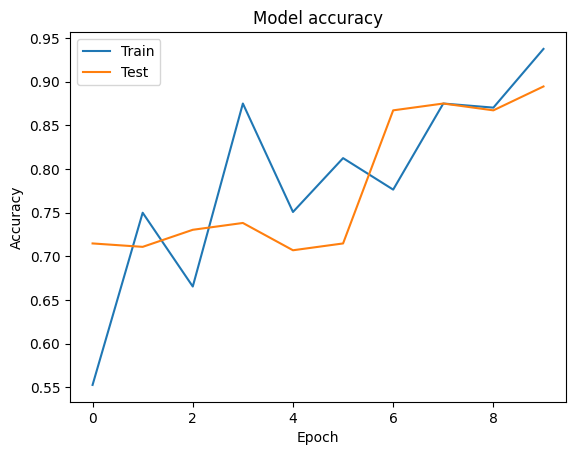

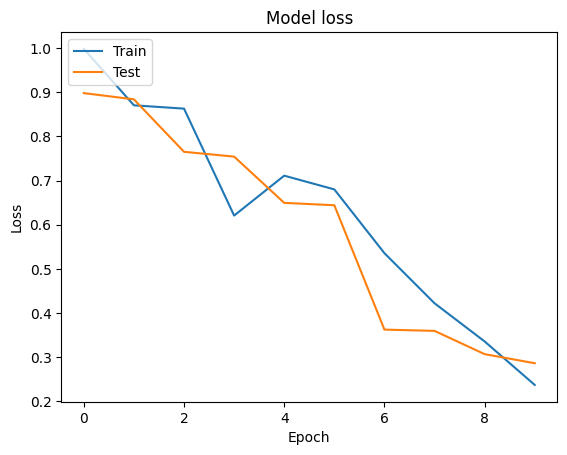

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Prepare data generators
def prepare_data(input_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(input_dir, 'train'),
        batch_size=16,
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(input_dir, 'val'),
        batch_size=16,
        class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(input_dir, 'test'),
        batch_size=16,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

# Build CNN model with GlobalAveragePooling2D to avoid shape mismatch
def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Use GlobalAveragePooling2D instead of Flatten
        layers.GlobalAveragePooling2D(),  # Automatically handles varying input sizes

        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # Adjust output size as per your classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main script
if __name__ == "__main__":
    input_dir = "/content/drive/MyDrive/dataset/split_preprocessed"

    # Prepare data
    train_generator, val_generator, test_generator = prepare_data(input_dir)

    # Build model
    input_shape = train_generator.image_shape  # Dynamically get the input shape
    model = build_cnn_model(input_shape)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    # Calculate steps
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = val_generator.samples // val_generator.batch_size

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )

    # Save model
    model_save_path = "/content/drive/MyDrive/models/tobacco_leaf_cnn.h5"
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc}")

    # Plot accuracy and loss
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

# Prepare data generators
def prepare_data(input_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(input_dir, 'train'),
        batch_size=16,
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(input_dir, 'val'),
        batch_size=16,
        class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(input_dir, 'test'),
        batch_size=16,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

# Build ResNet50 model
def build_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model (ResNet50) to avoid updating during training
    base_model.trainable = False

    # Build the top model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')  # Adjust output size as per your classes (3 classes)
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main script
if __name__ == "__main__":
    input_dir = "/content/drive/MyDrive/dataset/split_preprocessed"  # Adjust this to your directory

    # Prepare data
    train_generator, val_generator, test_generator = prepare_data(input_dir)

    # Build model
    input_shape = train_generator.image_shape  # Dynamically get the input shape from the data generator
    model = build_resnet_model(input_shape)

    # Calculate steps
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = val_generator.samples // val_generator.batch_size

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=val_generator,
        validation_steps=validation_steps
    )

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc}")


Found 406 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.4716 - loss: 1.2937 - val_accuracy: 0.5208 - val_loss: 1.0596
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.4375 - loss: 1.2078 - val_accuracy: 0.3333 - val_loss: 1.1263
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.4659 - loss: 1.0642 - val_accuracy: 0.5417 - val_loss: 0.9598
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.5625 - loss: 1.0229 - val_accuracy: 0.0000e+00 - val_loss: 1.0924
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.4947 - loss: 0.9893 - val_accuracy: 0.5000 - val_loss: 0.9618
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5000 - loss: 1.0357 - val_accuracy: 0.6667 - val_loss: 1.0750
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accurac

Found 406 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 20,557,891 (78.42 MB)

 Trainable params: 5,840,131 (22.28 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 335s 28s/step - accuracy: 0.6042 - loss: 0.8850 - val_accuracy: 0.7396 - val_loss: 0.7975
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 417ms/step - accuracy: 0.8125 - loss: 0.4936 - val_accuracy: 1.0000 - val_loss: 0.5575
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 327s 28s/step - accuracy: 0.9093 - loss: 0.2644 - val_accuracy: 0.7708 - val_loss: 0.7455
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.9062 - loss: 0.1727 - val_accuracy: 0.6667 - val_loss: 0.6167
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 328s 28s/step - accuracy: 0.9438 - loss: 0.1899 - val_accuracy: 0.6875 - val_loss: 0.6836
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 1.0000 - loss: 0.0842 - val_accuracy: 0.6667 - val_loss: 0.7272
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 363s 28s/step - accuracy: 0.9676 - loss: 0.0762 - val_accuracy: 0.7917 - val_loss: 0.5857
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9688 - loss: 0.0844 - val_accuracy: 0.8333 

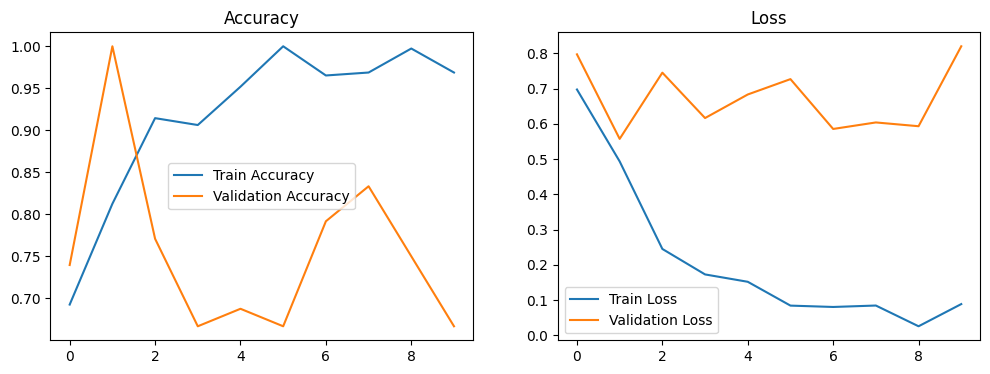

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Prepare Data Generators
def prepare_data(input_dir, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        os.path.join(input_dir, 'train'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_generator = datagen.flow_from_directory(
        os.path.join(input_dir, 'val'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_generator = datagen.flow_from_directory(
        os.path.join(input_dir, 'test'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    return train_generator, val_generator, test_generator

# Create a Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the residual connection

    # First Convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Second Convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    # Residual Connection
    if x.shape[-1] != shortcut.shape[-1]:  # Match dimensions if necessary
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

# Build ResNet Model with Pre-trained VGG16
def build_resnet_vgg16(input_shape, num_classes):
    # Load pre-trained VGG16 base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Add Residual Blocks on top
    x = base_model.output
    x = residual_block(x, 256)
    x = residual_block(x, 512)

    # Global Pooling and Dense Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Main Script
if __name__ == "__main__":
    input_dir = "/content/drive/MyDrive/dataset/split_preprocessed"
    batch_size = 32

    # Prepare data
    train_generator, val_generator, test_generator = prepare_data(input_dir, batch_size)
    input_shape = (224, 224, 3)  # VGG16 requires this input size
    num_classes = len(train_generator.class_indices)  # Number of output classes

    # Build and Train Model
    model = build_resnet_vgg16(input_shape, num_classes)
    model.summary()

    steps_per_epoch = train_generator.samples // batch_size
    validation_steps = val_generator.samples // batch_size

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=val_generator,
        validation_steps=validation_steps
    )

    # Evaluate Model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc}")

    # Plot Training History
    def plot_history(history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.legend()

        plt.show()

    plot_history(history)
